In [110]:

from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, 'C:/Users/igorl/CMF/reporting-forecasting')
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from functions.read_table import read_table
from tqdm import tqdm


pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [6]:
train_dir = '../data/oil_gas_train/'

df = pd.concat([read_table(os.path.join(train_dir, file), file)
               for file in tqdm(os.listdir(train_dir))])

company_names = df['Company_name'].copy()
df.columns = ['{}_{}'.format(col, i) for i, col in enumerate(df.columns)]
df = df[df.columns[df.nunique(dropna=False) > 1]]
df = df.apply(pd.to_numeric, errors='coerce')
df.iloc[:, -1] = company_names
df.shape

100%|██████████| 54/54 [00:09<00:00,  5.98it/s]


(2056, 282)

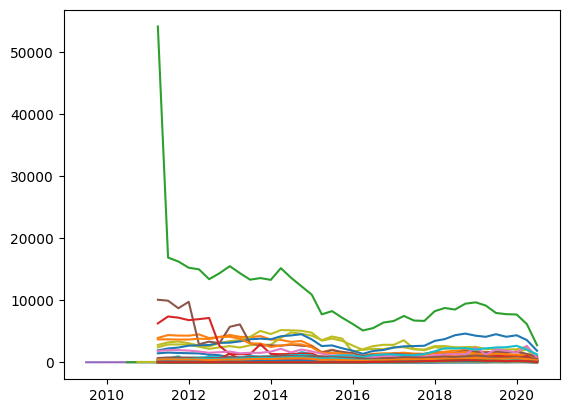

In [28]:
for company in df[df.columns[-1]].unique():
    plt.plot(
        df[df[df.columns[-1]] == company].index,
        df[df[df.columns[-1]] == company].Revenue_0.values, label=company)

plt.show()

In [113]:
target_columns = ['Revenue_0', 'Operating Income_14']
feature_columns = df.columns.drop(target_columns + ['Company_name_329'])

imp_mean = SimpleImputer(
    missing_values=np.nan,
    strategy='constant',
    fill_value=0,
).fit(df[feature_columns])

regr = MultiOutputRegressor(Ridge()).fit(
    imp_mean.fit_transform(df[feature_columns]), df[target_columns])

pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])

X = df[feature_columns]
y = df[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pipe.fit(X_train, y_train)
mean_squared_error(pipe.predict(X_test), y_test)

3.6123934197711467

Feature engineering 

In [142]:
df['month'] = pd.Series(df.index, dtype='datetime64[ns]').dt.month.values
df['month_sin'] = np.sin(2 * np.pi * df['month']/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12.0)

C:\Users\igorl\AppData\Local\Temp\ipykernel_3592\3900171797.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df['month'] = pd.Series(df.index, dtype='datetime64[ns]').dt.month.values


In [195]:
target_columns = ['Revenue_0', 'Operating Income_14']
feature_columns = df.columns.drop(target_columns+['Company_name_329'])
feature_columns = feature_columns[:79]

imp_mean = SimpleImputer(
    missing_values=np.nan,
    strategy='constant',
    fill_value=0,
).fit(df[feature_columns])

regr = MultiOutputRegressor(Ridge())

pipe = Pipeline([('imputer', imp_mean), ('regr', regr)])

X = df[feature_columns]
y = df[target_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

pipe.fit(X_train, y_train)
mean_squared_error(pipe.predict(X_test), y_test)

3.575668103684225

In [228]:
y_test.shape[0]

679

In [230]:
dummy_model = pd.DataFrame({'col1': np.full(y_test.shape[0], df['Revenue_0'].mean()),
                            'col2': np.full(y_test.shape[0], df['Operating Income_14'].mean())})

mean_squared_error(dummy_model, y_test)


1322536.487107317

Time series